In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data Preparation

In [4]:
columns_to_use = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 
                  'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

In [5]:
df = df[columns_to_use]

In [6]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [7]:
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [8]:
print(df.isnull().sum())
df = df.fillna(0)
print(df.isnull().sum())

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64
make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64


In [9]:
df["above_average"] = (df.msrp > df.msrp.mean()).astype(int)

### Train Test Splits

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
y = df.above_average.values

In [12]:
X = df.drop(columns = ['msrp', 'above_average'])

In [13]:
X.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [14]:
df_full_train, df_test, y_full_train, y_test = (
train_test_split(X, y, test_size=0.2, random_state=1))

In [15]:
df_train, df_val, y_train, y_val = (
train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1))

In [16]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

### ROC AUC Feature Importance

In [17]:
auc_columns = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [18]:
df_auc = df_train[auc_columns]

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit_transform(df_auc)

array([[0.27972028, 0.375     , 0.04678363, 0.14728682],
       [0.2997003 , 0.375     , 0.05263158, 0.07751938],
       [0.25874126, 0.25      , 0.04385965, 0.08527132],
       ...,
       [0.12987013, 0.25      , 0.07309942, 0.18604651],
       [0.16183816, 0.3125    , 0.02339181, 0.0620155 ],
       [0.23976024, 0.375     , 0.01754386, 0.04651163]])

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
auc_train = scaler.fit_transform(df_auc)
auc_train = pd.DataFrame(auc_train, columns = auc_columns)
for c in auc_train.columns:
    y_pred = (auc_train[c] > 0.5).astype(int)
    score = roc_auc_score(y_train, y_pred)
    if score < 0.5:
        y_pred = (-auc_train[c] > 0.5).astype(int)
        score = roc_auc_score(y_train, y_pred)
    print(f"AUC with {c}: {score}")    

AUC with engine_hp: 0.5791090629800307
AUC with engine_cylinders: 0.5473938320502946
AUC with highway_mpg: 0.5002560163850487
AUC with city_mpg: 0.5016901023917697


Among the numerical features, 'engine_hp' does the segregation of observations the most accurately.

### Training the model

In [24]:
from sklearn.feature_extraction import DictVectorizer

In [25]:
dv = DictVectorizer(sparse=False)

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
df_train.make.dtype

dtype('O')

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7148 entries, 0 to 7147
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               7148 non-null   object 
 1   model              7148 non-null   object 
 2   year               7148 non-null   int64  
 3   engine_hp          7148 non-null   float64
 4   engine_cylinders   7148 non-null   float64
 5   transmission_type  7148 non-null   object 
 6   vehicle_style      7148 non-null   object 
 7   highway_mpg        7148 non-null   int64  
 8   city_mpg           7148 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 502.7+ KB


In [51]:
numerical = [x for x in df_train.columns if df_train[x].dtype != 'O']
categorical = [x for x in df_train.columns if x not in numerical]
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [52]:
df_train_numeric = df_train[numerical]
df_train_numeric = pd.DataFrame(scaler.fit_transform(df_train_numeric), 
                               columns = numerical)
df_train_numeric.head()

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
0,0.962963,0.279720,0.375,0.046784,0.147287
1,0.888889,0.299700,0.375,0.052632,0.077519
2,0.962963,0.258741,0.250,0.043860,0.085271
3,0.925926,0.279720,0.375,0.038012,0.069767
4,0.962963,0.282717,0.375,0.038012,0.069767


In [53]:
df_val_numeric = df_val[numerical]
df_val_numeric = pd.DataFrame(scaler.transform(df_val_numeric), 
                               columns = numerical)

In [54]:
df_train_categoric = df_train[categorical]
df_train = pd.concat([df_train_numeric, df_train_categoric], axis = 1)

In [55]:
df_val_categoric = df_val[categorical]
df_val = pd.concat([df_val_numeric, df_val_categoric], axis = 1)

In [56]:
lr = LogisticRegression(solver = 'liblinear', 
                        C=1.0, 
                        max_iter=1000)

In [57]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [58]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred_prob = lr.predict_proba(X_val)[:,1]
y_pred_prob

array([0.470626  , 0.02315984, 0.34585213, ..., 0.0124964 , 0.99643081,
       0.06897637])

In [59]:
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [60]:
roc_auc = roc_auc_score(y_val, y_pred)

In [61]:
roc_auc

0.9250202959763558

In [62]:
abs(roc_auc - 0.878)

0.04702029597635582

In [63]:
abs(roc_auc - 0.979)

0.05397970402364416

### Precision and Recall

In [64]:
thresholds = np.arange(0.0, 1.0, 0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [65]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

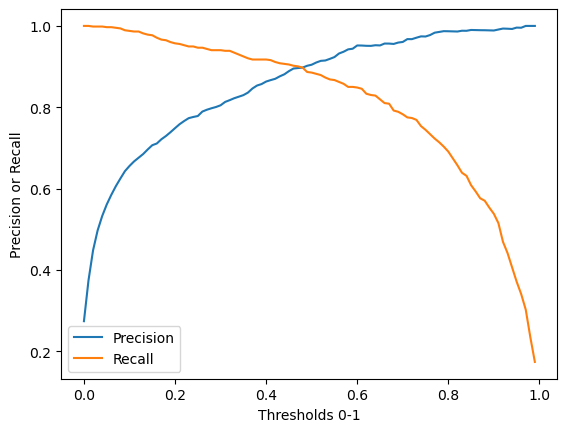

In [66]:
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_pred_prob > t).astype(int)
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    precisions.append(p)
    recalls.append(r)
    
plt.plot(thresholds, precisions, label = 'Precision')
plt.plot(thresholds, recalls, label = 'Recall')
plt.xlabel("Thresholds 0-1")
plt.ylabel("Precision or Recall")
plt.legend()
plt.show()

### F1 Score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the $F1$ score - a metrics that takes into account both

This is the formula for computing $F1$:
                $$F{1} = 2.(P.R)/(P+R)$$
 

Where 
$P$ is precision and 
$R$ is recall.

Threshold for max F1: 0.46


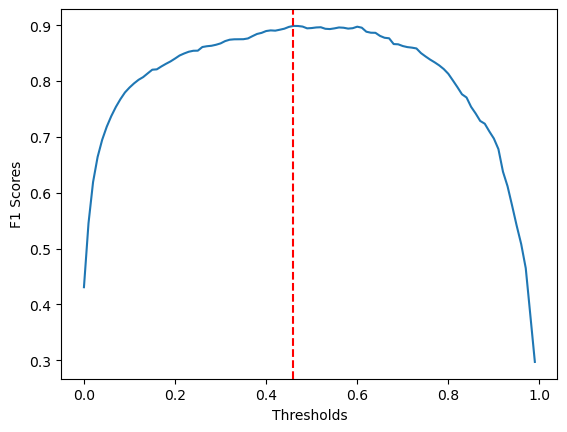

In [68]:
f1 = []

max_f1 = 0 
max_f1_threshold = 0
for t in thresholds:
    y_pred = (y_pred_prob > t).astype(int)
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    score = 2*p*r/(p+r)
    if score > max_f1:
        max_f1 = score
        max_f1_threshold = t
    f1.append(score)

print(f"Threshold for max F1: {max_f1_threshold}")
    
plt.plot(thresholds, f1, label = 'F1 - Scores')
plt.xlabel("Thresholds")
plt.ylabel("F1 Scores")
plt.axvline(max_f1_threshold, color = 'red', ls = '--')
plt.show()